## Main Notebook: NLP Series Workshop 1: Getting Started with Sentiment Analysis

<span style="color:red">__DISCLAIMER__</span> : This dataset contains hateful speech and explicit content. 

Conventions used:

❗ - Required <br>
❓ - Question

## 1. Setup and Exploration

### a. Setup

The dataset we'll use can be found here: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [ ]:
import gdown
!mkdir twitter-sentiment
%cd twitter-sentiment
gdown.download('https://drive.google.com/uc?export=download&id=1tMrkYFAuzjCWjhDCJRGqVNLd4j0XrlVK')
!unzip -q twitter-sentiment-analysis-hatred-speech.zip
!rm twitter-sentiment-analysis-hatred-speech.zip

/content/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment


Downloading...
From: https://drive.google.com/uc?export=download&id=1tMrkYFAuzjCWjhDCJRGqVNLd4j0XrlVK
To: /content/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment/twitter-sentiment-analysis-hatred-speech.zip
100%|██████████| 1.98M/1.98M [00:00<00:00, 82.9MB/s]


Import Libraries

In [ ]:
# General imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Rule-Based imports
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter('ignore')

# NLP imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

Load Datasets with Pandas

In [ ]:
train_csv = pd.read_csv("/content/twitter-sentiment/train.csv")
test_csv = pd.read_csv("/content/twitter-sentiment/test.csv")

### b. Exploration

Best practice is to completely ignore the test data so we can avoid snooping bias! For now, we will explore the train CSV. Colab has a great new feature that allows you to explore tables, but today we will stick with using `pandas`.

In [ ]:
train_csv

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


The above visualization of our dataset tells us a few things:
1. There are three categories: id, label, and tweet;
2. Tweets are labeled 0 or 1 (0 for not racist/sexist and 1 for racist/sexist);
3. tweets include @'s (@user), #'s, and normal text

Let's generate some word clouds (for common words for racist/sexist sentiment and not racist/sexist sentiment). From there, we can code some rules that leverage these common words (i.e. if this word is in this sentence, then it most likely belongs to this class).

Courtesy of [G2G's Word Cloud demo](https://www.geeksforgeeks.org/generating-word-cloud-python/#:~:text=For%20generating%20word%20cloud%20in%20Python%2C%20modules%20needed,cloud%20is%20collected%20from%20UCI%20Machine%20Learning%20Repository.?msclkid=8ca68647c2a011eca8ed503ab24c070b).

In [ ]:
# Filter tweets into 2 buckets: not racist/sexist, and racist/sexist.
positive = train_csv[train_csv['label']==0]
negative = train_csv[train_csv['label']==1] 

# Convert these tweets into a list of tweet strings.
positive = positive["tweet"].tolist()
negative = negative["tweet"].tolist()

# Note: we will remove @user and amp, since these are generic replacements for actual @'s
positive_str = " ".join(positive).replace("@user", "").replace("amp", "").replace("  ", " ")
negative_str = " ".join(negative).replace("@user", "").replace("amp", "").replace("  ", " ")

print(f"# of positive tweets: {len(positive)}")
print(f"# of negative tweets: {len(negative)}")

# of positive tweets: 29720
# of negative tweets: 2242


In [ ]:
def plot_word_cloud(word_cloud):
  plt.figure(figsize = (8, 8), facecolor=None)
  plt.imshow(word_cloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  
  plt.show()

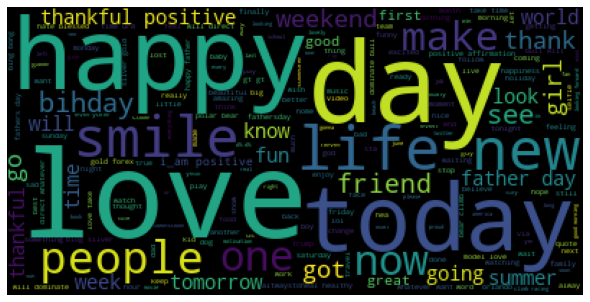

In [ ]:
word_cloud_pos = WordCloud().generate(positive_str)
plot_word_cloud(word_cloud_pos)

It seems words like "love", "life", "happy", "smile", "friend", "day", "new", and "amp" in this dataset indicate "not racist/sexist" sentiment. 

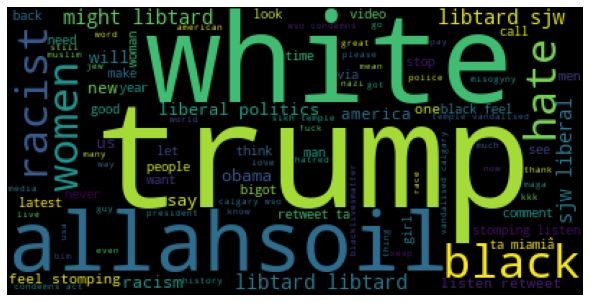

In [ ]:
word_cloud_neg = WordCloud().generate(negative_str)
plot_word_cloud(word_cloud_neg)

We can see that "racist/sexist" sentiment includes words like "trump", "racist", "libtard", "white", "black", "women", "allah", and more.

## 2. Rule-Based Classifier

Using our word clouds, we can try tackling our problem with a rule-based classifier.

❓: What is a __rule-based classifier__?

> __rule-based classifier__ : a classifier that is based on a set of user-defined rules (e.g. IF this THEN this).

We're going to use the most common terms from the negative word cloud to create a rule-based classifier.

### a. Building the Rule-based Classifier

In [ ]:
def rule_model(tweet):

  # List of words we deem negative
  hate_words = ["women", "black", "white", "libtard", 
                "trump", "hate", "sjw", "allahsoil", 
                "politics", "bigot", "racist", "racism"]

  # return 1 if tweet includes any of hate_words; return 0 otherwise
  return 1 if any(word in tweet for word in hate_words) else 0

First thing to notice: The model is super simple and easily interpretable! But the rules have to be investigated and coded by hand. Let's evaluate its accuracy.

### b. Evaluating the Rule-based Classifier

First, we want to split our data into **train** data and **validation** data.

For now, we will not worry about the different kinds of data. We will, however, use our **validation** data to verify the success of our rule-based classifier

In [ ]:
train_tweets, val_tweets, train_labels, val_labels = \
  train_test_split(train_csv["tweet"].values, train_csv["label"].values, \
                   test_size=0.1, random_state=806)

Let's generate our predictions on the validation data:

In [ ]:
# generate rule predicitions for val_tweets
rule_predictions = [rule_model(val_tweet) for val_tweet in val_tweets]

Now that we have our predictions, let's see how accurate our model is!

We'll be using three metrics:
- accuracy: % correctly labelled
- precision: measures 'quality' (out of how many i guessed positive/negative, how many of those are actually positive/negative?)
- recall: measures 'quantity' (out of all actual positives/negatives in the dataset, how many of those did we label as positive/negative?)

You can read up on the math behind precision/recall here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [ ]:
# accuracy_score() calculates accuracy
rule_accuracy = accuracy_score(val_labels, rule_predictions)

# call confusion_matrix() again
rule_matrix = confusion_matrix(val_labels, rule_predictions)

# math for precision and recall
rule_precision = rule_matrix[1][1]/(rule_matrix[1][1]+rule_matrix[0][1])
rule_recall = rule_matrix[1][1]/(rule_matrix[1][1]+rule_matrix[1][0])

# print results
print('Rule-based accuracy: {:0.4f}'.format(rule_accuracy))
print('Rule-based words precision: {:0.4f}'.format(rule_precision))
print('Rule-based words recall: {:0.4f}'.format(rule_recall))

Rule-based accuracy: 0.9124
Rule-based words precision: 0.3935
Rule-based words recall: 0.3632


Our accuracy is okay, but our precision and recall are terrible. This indicates a "class imabalance" in our dataset.

> __class imbalance__: when the distribution of examples across known classes in the dataset are biased or skewed

## 3. NLP Classifier

### a. Intro to Bag of Words

❓: What is a __bag of words__?

> __bag of words__ : a simple NLP representation of sentences to make text readable by computers

Language is easy for us humans to read, but computers only understand things like 1s and 0s, vectors, etc. So, we need a representation that converts text into a format a computer can understand.

Bag of Words is one such representation. It takes ordinary sentences and turns them into a set of vectors that the computer can understand.

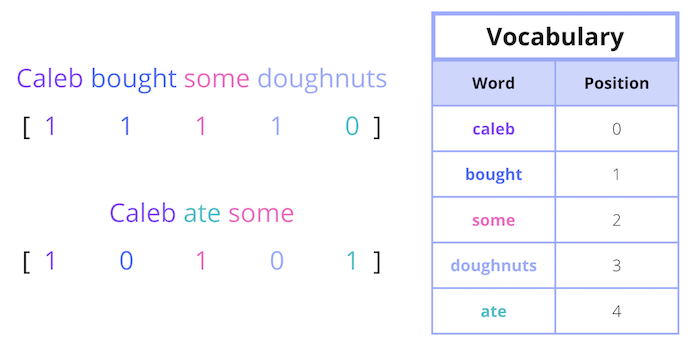

It's called a 'bag of words' because it's just a count of different words; the words have no relationship with each other.

Take the following example:

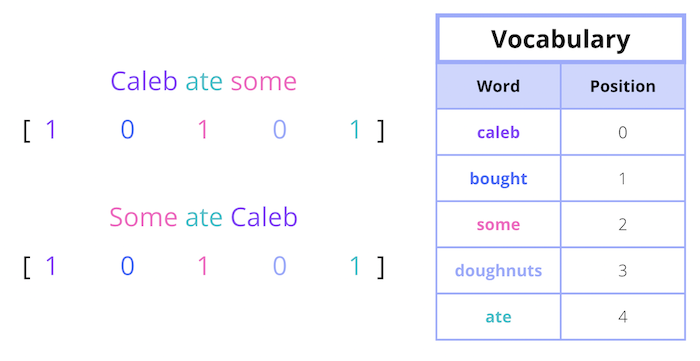

"Caleb ate some" has a wildly different meaning from "Some ate Caleb"; yet, a bag of words represenation thinks they're the same.

### b. Bag of Words + Logistic Regression

Now we're ready to build our model!

Recall our train/validation split from earlier:

```
train_tweets, val_tweets, train_labels, val_labels = \
        train_test_split(train_csv["tweet"].values, train_csv["label"].values, \
                          test_size=0.1, random_state=806)
```

Train data will help train our model, while validation data will verify how accurate our model is. A majority of our data is for training.

We'll use the `CountVectorizer()` function from `sklearn` to create a Bag of Words representation of our data.

In [ ]:
# create a CountVectorizer which filters our defined stopwords
bow_vectorizer = CountVectorizer(stop_words=['@user', 'amp'])

# convert train_tweets to bag of words
bow_train_vect = bow_vectorizer.fit_transform(train_tweets)

We now want to connect our Bag of Words representation to an ML Model to do some machine learning. First, we will use logistic regression.

❓: What is __logistic regression__?

> __logistic regression__ : a simple ML model which separates data points into classes (0 or 1 in our case) by altering a logistic curve

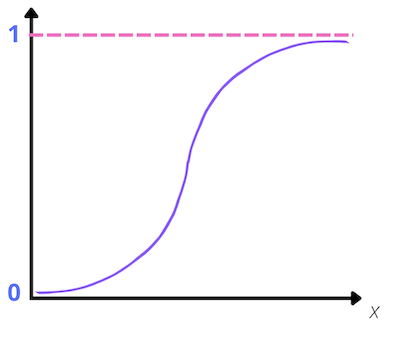

Logistic Regression is a simple ML model. We won't cover specfics of non-NLP models in this series, but you can think of the `LogisticRegresion()` function as a 'black box'. You throw in an input (our bag of words), and you get an output (each tweet labelled as 0 or 1).

In [ ]:
# train our LogisticRegression model on train data
bow_model = LogisticRegression()
bow_model.fit(bow_train_vect, train_labels)


# apply model to validation data, save predictions
bow_val_vect = bow_vectorizer.transform(val_tweets)
bow_predictions = bow_model.predict(bow_val_vect)

Let's generate accuracy, precision, and recall for the Bag of Words + Logistic Regression Model!

In [ ]:
# accuracy_score() calculates accuracy
bow_accuracy = accuracy_score(val_labels, bow_predictions)

# confusion_matrix() computes true positive, true negative, false positive, false negative
bow_matrix = confusion_matrix(val_labels, bow_predictions)

# math for precision and recall
bow_precision = bow_matrix[1][1]/(bow_matrix[1][1]+bow_matrix[0][1])
bow_recall = bow_matrix[1][1]/(bow_matrix[1][1]+bow_matrix[1][0])

# print results
print('Bag of words accuracy: {:0.4f}'.format(bow_accuracy))
print('Bag of words precision: {:0.4f}'.format(bow_precision))
print('Bag of words recall: {:0.4f}'.format(bow_recall))

Bag of words accuracy: 0.9628
Bag of words precision: 0.8966
Bag of words recall: 0.5556


### c. Bag of Words + Logistic Regression vs Rule-Based

Comparing our Bag of Words + Logistic Regression model to our Rule-based classifier, we get the following results:

|             | Bag of Words | Rule-Based  |
| ----------- | -----------  | ----------- |
| Accuracy    | $.9628$      | $.9128$     |
| Precision   | $.8966$      | $.3935$     |
| Recall      | $.5556$      | $.3632$     |

Accuracy seems okay in Rule-Based, but Bag of Words is better.

Precision and recall are terrible in Rule-Based ($\lt.4$)!

Bag of words is more precise (higher quality) and has better, though not amazing, recall (so it gets more of relevant results).

### d. Bag of Words + Neural Net

Let's try connecting up our Bag of Words representation to a different model! We'll try using a Neural Net.

The code is virtually the same. The only difference is we replace `LogisticRegression()` with `sklearn`'s `MLPClassifier()`. `MLPClassifier()` passes your input data into a customizable neural net, and will return an appropriate set of classified predictions!

❓: What is a __neural net__?

> __neural net__ : an ML model based on the human brain; large neural networks with many hidden layers are used in deep learning

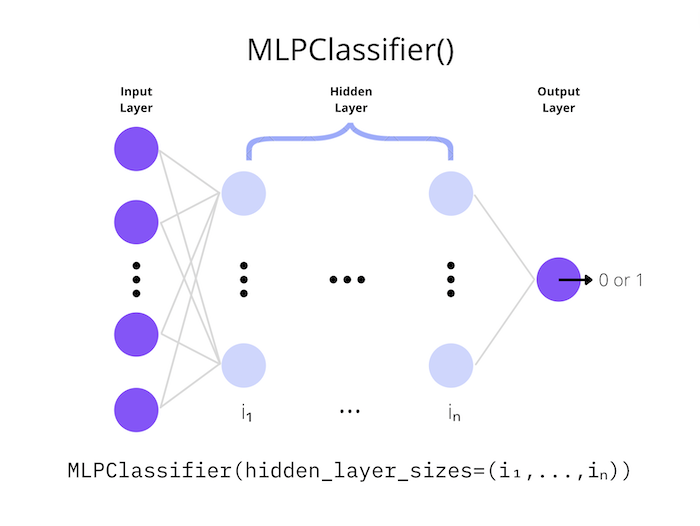

Check out this link for a guide to `MLPClassifier()` and its many props (including `max_iter`, `activation`, `learning_rate`, etc) to optimize a neural net: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Recall the steps:
1. create `bow_nnet_model` as `MLPClassifier()` from `sklearn`
2. train `bow_nnet_model` on train data
3. apply `bow_nnet_model` to validation data and save predictions in `bow_nnet_predictions`
4. compute accuracy, precision, and recall, of `bow_nnet_predictions` and print


Note that `bow_train_vect` and `bow_val_vect` were already generated when we made the Bag of Words + Logistic Regression model

Also note that the nnet will take about 7 mins to run on standard Colab.

In [ ]:
from sklearn.neural_network import MLPClassifier

# train our Nnet model (MLP = Multi-Layer Perceptron)
bow_nnet_model = MLPClassifier(random_state=1, max_iter=300)
bow_nnet_model.fit(bow_train_vect, train_labels)

# apply nnet model to val_tweets bag of words; save our predictions
bow_nnet_predictions = bow_nnet_model.predict(bow_val_vect)

# accuracy_score() calculates accuracy
bow_nnet_accuracy = accuracy_score(val_labels, bow_nnet_predictions)

# confusion_matrix() computes true positive, true negative, false positive, false negative
bow_nnet_matrix = confusion_matrix(val_labels, bow_nnet_predictions)

# math for precision and recall
bow_nnet_precision = bow_nnet_matrix[1][1]/(bow_nnet_matrix[1][1]+bow_nnet_matrix[0][1])
bow_nnet_recall = bow_nnet_matrix[1][1]/(bow_nnet_matrix[1][1]+bow_nnet_matrix[1][0])

# print results
print('Bag of words accuracy: {:0.4f}'.format(bow_nnet_accuracy))
print('Bag of words precision: {:0.4f}'.format(bow_nnet_precision))
print('Bag of words recall: {:0.4f}'.format(bow_nnet_recall))

Bag of words accuracy: 0.9643
Bag of words precision: 0.7885
Bag of words recall: 0.7009


Comparing to the Bag of Words + Logistic Regression and Rule-Based Classifier:

|             | BoW Nnet    | BoW LogReg   | Rule-Based  |
| ----------- | ----------- | -----------  | ----------- |
| Accuracy    | $.9643$     | $.9628$      | $.9128$     |
| Precision   | $.7885$     | $.8966$      | $.3935$     |
| Recall      | $.7009$     | $.5556$      | $.3632$     |

Precision is somewhat lower than Bag of Words and Logistic Regression, but Recall is much better than before!

## 4. Conclusion

Bag of Words is a very simple NLP representation, but it still outperformed our rule-based classifier in every metric.

Further, hooking up our Bag of Words representation to different ML Models (Logistic Regression and an Nnet) produced different results. Overall, however, there is a cap in overall accuracy of the model (about 96%).

More complicated NLP models can perform more detailed analysis, and result in higher precision and recall, which we will explore in our second NLP workshop next week!